Analyzing submission.csv...


   n  box_side  box_area   density  tree_count
0  1  0.813173  0.661250  0.371456           1
1  2  0.949504  0.901558  0.544890           2
2  3  1.142031  1.304235  0.564986           3
3  4  1.290806  1.666179  0.589672           4
4  5  1.443692  2.084248  0.589241           5

Top 20 Worst Packings (Lowest Density):
     n  box_side  box_area   density  tree_count
0    1  0.813173  0.661250  0.371456           1
1    2  0.949504  0.901558  0.544890           2
2    3  1.142031  1.304235  0.564986           3
4    5  1.443692  2.084248  0.589241           5
3    4  1.290806  1.666179  0.589672           4
6    7  1.673104  2.799276  0.614221           7
5    6  1.548438  2.397662  0.614661           6
8    9  1.867280  3.486735  0.634010           9
7    8  1.755921  3.083258  0.637313           8
14  15  2.384962  5.688043  0.647740          15
9   10  1.940696  3.766300  0.652165          10
20  21  2.811667  7.905469  0.652476          21
19  20  2.742469  7.521137  0.653159    

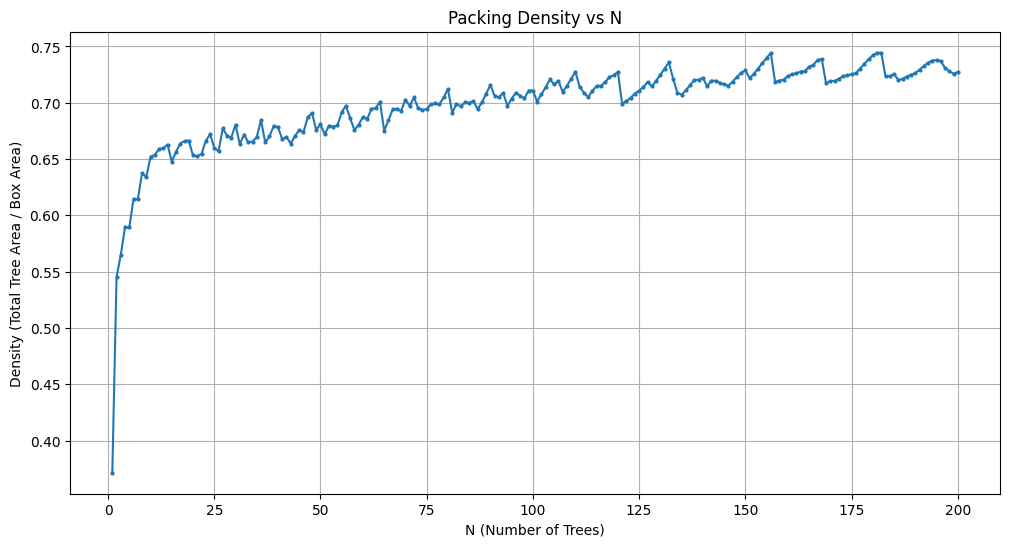

In [1]:
import pandas as pd
import numpy as np
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import seaborn as sns

# Set precision
getcontext().prec = 30
scale_factor = Decimal("1")

class ChristmasTree:
    def __init__(self, center_x="0", center_y="0", angle="0"):
        self.center_x = Decimal(str(center_x))
        self.center_y = Decimal(str(center_y))
        self.angle = Decimal(str(angle))

        trunk_w = Decimal("0.15")
        trunk_h = Decimal("0.2")
        base_w = Decimal("0.7")
        mid_w  = Decimal("0.4")
        top_w  = Decimal("0.25")
        tip_y = Decimal("0.8")
        tier_1_y = Decimal("0.5")
        tier_2_y = Decimal("0.25")
        base_y = Decimal("0.0")
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon(
            [
                (Decimal("0.0") * scale_factor, tip_y * scale_factor),
                (top_w / Decimal("2") * scale_factor, tier_1_y * scale_factor),
                (top_w / Decimal("4") * scale_factor, tier_1_y * scale_factor),
                (mid_w / Decimal("2") * scale_factor, tier_2_y * scale_factor),
                (mid_w / Decimal("4") * scale_factor, tier_2_y * scale_factor),
                (base_w / Decimal("2") * scale_factor, base_y * scale_factor),
                (trunk_w / Decimal("2") * scale_factor, base_y * scale_factor),
                (trunk_w / Decimal("2") * scale_factor, trunk_bottom_y * scale_factor),
                (-(trunk_w / Decimal("2")) * scale_factor, trunk_bottom_y * scale_factor),
                (-(trunk_w / Decimal("2")) * scale_factor, base_y * scale_factor),
                (-(base_w / Decimal("2")) * scale_factor, base_y * scale_factor),
                (-(mid_w / Decimal("4")) * scale_factor, tier_2_y * scale_factor),
                (-(mid_w / Decimal("2")) * scale_factor, tier_2_y * scale_factor),
                (-(top_w / Decimal("4")) * scale_factor, tier_1_y * scale_factor),
                (-(top_w / Decimal("2")) * scale_factor, tier_1_y * scale_factor),
            ]
        )

        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(
            rotated,
            xoff=float(self.center_x * scale_factor),
            yoff=float(self.center_y * scale_factor),
        )

    def clone(self):
        return ChristmasTree(center_x=str(self.center_x), center_y=str(self.center_y), angle=str(self.angle))

def parse_csv(csv_path):
    df = pd.read_csv(csv_path)
    df["x"] = df["x"].astype(str).str.strip().str.lstrip("s")
    df["y"] = df["y"].astype(str).str.strip().str.lstrip("s")
    df["deg"] = df["deg"].astype(str).str.strip().str.lstrip("s")
    df[["group_id", "item_id"]] = df["id"].str.split("_", n=2, expand=True)
    
    dict_of_tree_list = {}
    for group_id, group_data in df.groupby("group_id"):
        tree_list = [
            ChristmasTree(center_x=row["x"], center_y=row["y"], angle=row["deg"])
            for _, row in group_data.iterrows()
        ]
        dict_of_tree_list[int(group_id)] = tree_list
    return dict_of_tree_list

def analyze_packing(submission_path):
    print(f"Analyzing {submission_path}...")
    tree_dict = parse_csv(submission_path)
    
    results = []
    
    # Calculate area of a single tree (it's constant)
    # Create a dummy tree to calculate area
    dummy_tree = ChristmasTree()
    tree_area = dummy_tree.polygon.area
    
    for n in sorted(tree_dict.keys()):
        trees = tree_dict[n]
        
        # Calculate bounding box
        all_polygons = [t.polygon for t in trees]
        union_poly = unary_union(all_polygons)
        bounds = union_poly.bounds
        width = bounds[2] - bounds[0]
        height = bounds[3] - bounds[1]
        box_side = max(width, height)
        box_area = box_side ** 2
        
        total_tree_area = tree_area * len(trees)
        density = total_tree_area / box_area
        
        score = (box_side ** 2) / n # This is not exactly the score formula?
        # Score formula is sum(side_length^2 / n) for all n.
        # But for a single n, the contribution is side_length^2 / n?
        # Wait, the problem statement says: Score = sum(side_length^2 / n)
        # No, wait. "Score is the sum of the area of the smallest square box... divided by N?"
        # Let's check the formula.
        # "For each N... find the smallest square side S_N... Score = Sum(S_N^2)"?
        # Re-reading prompt: "Score = sum(side_length^2 / n) for n=1..200"
        # Wait, usually it's Sum(Area). But here it says side_length^2 / n.
        # Let's assume the contribution is side_length^2.
        # Actually, let's just use Density as the metric for efficiency.
        
        results.append({
            "n": n,
            "box_side": box_side,
            "box_area": box_area,
            "density": density,
            "tree_count": len(trees)
        })
        
    df_results = pd.DataFrame(results)
    return df_results

df_analysis = analyze_packing("submission.csv")
print(df_analysis.head())

# Sort by density (ascending) to find worst packings
worst_packings = df_analysis.sort_values("density").head(20)
print("\nTop 20 Worst Packings (Lowest Density):")
print(worst_packings)

# Save worst Ns to a file for the optimizer to read
worst_ns = worst_packings["n"].tolist()
import json
with open("worst_ns.json", "w") as f:
    json.dump(worst_ns, f)

# Plot density vs N
plt.figure(figsize=(12, 6))
plt.plot(df_analysis["n"], df_analysis["density"], marker='o', markersize=2, linestyle='-')
plt.title("Packing Density vs N")
plt.xlabel("N (Number of Trees)")
plt.ylabel("Density (Total Tree Area / Box Area)")
plt.grid(True)
plt.savefig("density_vs_n.png")
